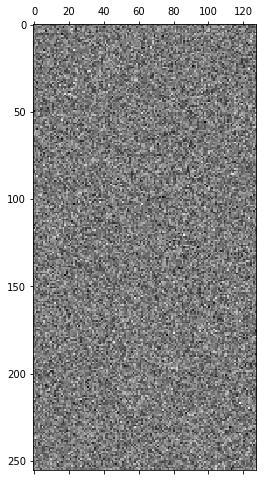

In [7]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np

n_examples = int(1e5)
n_dims = 128

def unit_vectors(n_examples, n_dims):
    dense = np.random.normal(0, 1, (n_examples, n_dims))
    dense /= np.linalg.norm(dense, axis=-1, keepdims=True) + 1e-8
    return dense

dense = unit_vectors(n_examples, n_dims)

plt.matshow(dense[:256], cmap='gray')

In [ ]:
from scipy.spatial.distance

def brute_force_search(query, index):
    pass